In [2]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

In [1]:
# Cell 2

def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []  # Processed data after scaling
    original_data_frames = []  # Save the original unscaled data
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        # Keep a copy of the original data before scaling
        original_data_frames.append(df.copy())  # Save the original unmodified data
        
        # Process the data for use in the model
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        # Plot with a 90-degree right rotation (swap x and y)
        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(on_paper['x'], -on_paper['y'], c='blue', s=1, alpha=0.7, label='On Paper')  # Swap x and y, negate y
        axs[i].scatter(in_air['x'], -in_air['y'], c='red', s=1, alpha=0.7, label='In Air')  # Swap x and y, negate y
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('x')  # x-axis is 'x'
        axs[i].set_ylabel('-y')  # y-axis is '-y'
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames  # Return original data

directory = 'Task3'  # Directory where the .svc files are stored
num_files_to_use = 3
data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")


NameError: name 'os' is not defined

In [3]:
# Cell 3
# Process each DataFrame instead of just the first one
for df_idx in range(len(data_frames)):
    df = data_frames[df_idx]  # Using each DataFrame in the list

    # Convert the 'timestamp' column to numeric for calculations (if not already done)
    df['timestamp'] = pd.to_numeric(df['timestamp'])

    # Sort the DataFrame by timestamp (should already be sorted in the function)
    df.sort_values('timestamp', inplace=True)

    # Calculate the differences between consecutive timestamps (optional for gap finding)
    df['time_diff'] = df['timestamp'].diff()

    # Identify the indices where the time difference is greater than 30,000 milliseconds
    gap_indices = df.index[df['time_diff'] > 8].tolist()

    # Create an empty list to hold the new rows
    new_rows = []

    # Fill in the gaps with 70 milliseconds intervals
    for idx in gap_indices:
        # Check if the next index is valid
        if idx + 1 < len(df):
            # Get the current and next timestamps
            current_timestamp = df.at[idx, 'timestamp']
            next_timestamp = df.at[idx + 1, 'timestamp']

            # Calculate how many entries we need to fill in
            num_fill_entries = (next_timestamp - current_timestamp) // 7

            # Generate the timestamps to fill the gap
            for i in range(1, num_fill_entries + 1):
                new_timestamp = current_timestamp + i * 7

                # Create a new row to fill in with NaN for x and y
                new_row = {
                    'x': np.nan,  # Set x to NaN
                    'y': np.nan,  # Set y to NaN
                    'timestamp': new_timestamp,
                    'pen_status': 0,        # You can set this to your desired value
                    'azimuth': df.at[idx, 'azimuth'],   # Use the current azimuth value
                    'altitude': df.at[idx, 'altitude'], # Use the current altitude value
                    'pressure': df.at[idx, 'pressure']  # Use the current pressure value
                }

                # Append the new row to the list of new rows
                new_rows.append(new_row)

    # Create a DataFrame from the new rows
    new_rows_df = pd.DataFrame(new_rows)

    # Concatenate the original DataFrame with the new rows DataFrame
    df = pd.concat([df, new_rows_df], ignore_index=True)

    # Sort the DataFrame by timestamp to maintain order
    df.sort_values('timestamp', inplace=True)

    # Reset index after sorting
    df.reset_index(drop=True, inplace=True)

    # Interpolate NaN values in 'x' and 'y' columns based on nearest neighbors
    # Check for NaN entries before interpolation
    if df[['x', 'y']].isnull().any().any():
        df[['x', 'y']] = df[['x', 'y']].interpolate(method='linear')

    # Drop the 'time_diff' column after processing
    df.drop(columns=['time_diff'], inplace=True)

    # Update the processed data
    data_frames[df_idx] = df

# Update processed data for all DataFrames
processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                  for df, scaler in zip(data_frames, scalers)]
avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

In [4]:

# Cell 4
processed_dataframes = []

for input_filename, df in zip(input_filenames, data_frames):
    # Convert all numeric columns to integers
    df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']] = df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']].astype(int)
    
    # Append the processed DataFrame to the list
    processed_dataframes.append(df)

    print(f"Processed DataFrame for: {input_filename}")



Processed DataFrame for: u00001s00001_hw00002.svc
Processed DataFrame for: u00002s00001_hw00002.svc
Processed DataFrame for: u00003s00001_hw00002.svc
Processed DataFrame for: u00004s00001_hw00002.svc
Processed DataFrame for: u00005s00001_hw00002.svc


In [5]:
# Cell 5 (modified, no visualization)
def process_dataframes(dataframes, num_files_to_use=None):
    if num_files_to_use:
        dataframes = dataframes[:num_files_to_use]

    data_frames = []
    scalers = []

    for i, df in enumerate(dataframes):
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for DataFrame {i + 1}:")
        print(df['timestamp'].head())
        print("\n")

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, [f"DataFrame_{i+1}" for i in range(len(dataframes))]

# Use the processed_dataframes directly
data_frames, processed_data, scalers, avg_data_points, original_filenames = process_dataframes(processed_dataframes, num_files_to_use)
print(f"Number of processed files: {len(processed_data)}")
# print(f"Average number of data points: {avg_data_points}")


Modified timestamps for DataFrame 1:
0     0
1     7
2    15
3    22
4    30
Name: timestamp, dtype: int32


Modified timestamps for DataFrame 2:
0     0
1     7
2    15
3    22
4    30
Name: timestamp, dtype: int32


Modified timestamps for DataFrame 3:
0     0
1     7
2    15
3    22
4    30
Name: timestamp, dtype: int32


Modified timestamps for DataFrame 4:
0     0
1     7
2    15
3    22
4    30
Name: timestamp, dtype: int32


Modified timestamps for DataFrame 5:
0     0
1     8
2    15
3    23
4    30
Name: timestamp, dtype: int32


Number of processed files: 5


In [6]:
# Cell 6 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0, **kwargs):  # Added **kwargs to handle extra arguments
        super(VAE, self).__init__(**kwargs)  # Pass kwargs to the parent class
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),  # 4 for x, y, timestamp, pen_status
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # 4 for x, y, timestamp, pen_status
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])  # x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    @classmethod
    def from_config(cls, config):
        # Handle any unexpected keys like 'trainable' by removing them
        config.pop('trainable', None)
        config.pop('dtype', None)  # Also remove 'dtype' if included
        return cls(**config)

    def get_config(self):
        config = super(VAE, self).get_config()
        # Add the VAE-specific arguments
        config.update({
            'latent_dim': self.latent_dim,
            'beta': self.beta
        })
        return config


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# Parameters for VAE
latent_dim = 512
beta = 0.000001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [7]:
# Cell 7 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0)):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        selected_data = processed_data[i % num_input_files]
        
        # Retain original columns for pressure, azimuth, and altitude
        original_data = data_frames[i % num_input_files]  # Use original unprocessed data
        pressure_azimuth_altitude = original_data[['pressure', 'azimuth', 'altitude']].values
        
        # Determine the number of points for this augmented dataset
        # num_points = int(avg_data_points * (1 + np.random.uniform(-length_variability, length_variability)))
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        # Encode and reparameterize
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()
        
        # # Adjust number of points
        # if num_points > augmented_data.shape[0]:
        #     extra_indices = np.random.choice(augmented_data.shape[0], num_points - augmented_data.shape[0])
        #     augmented_data = np.vstack((augmented_data, augmented_data[extra_indices]))
        # elif num_points < augmented_data.shape[0]:
        #     keep_indices = np.random.choice(augmented_data.shape[0], num_points, replace=False)
        #     augmented_data = augmented_data[keep_indices]

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        # Append the pressure, azimuth, and altitude columns from the original data
        augmented_data = np.column_stack((augmented_data, pressure_azimuth_altitude[:augmented_data.shape[0]]))
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/200: 100%|██████████| 48/48 [00:25<00:00,  1.87batch/s, Generator Loss=0.0897, Reconstruction Loss=0.0897, KL Loss=0.0782]


Epoch 1: Generator Loss = 0.544891, Reconstruction Loss = 0.544891, KL Divergence Loss = 0.024265
NRMSE = 0.268586


Epoch 2/200: 100%|██████████| 48/48 [00:05<00:00,  8.63batch/s, Generator Loss=0.0611, Reconstruction Loss=0.0611, KL Loss=0.159]


Epoch 2: Generator Loss = 0.069423, Reconstruction Loss = 0.069423, KL Divergence Loss = 0.145409
NRMSE = 0.268671


Epoch 3/200: 100%|██████████| 48/48 [00:03<00:00, 14.64batch/s, Generator Loss=0.0603, Reconstruction Loss=0.0603, KL Loss=0.211]


Epoch 3: Generator Loss = 0.056361, Reconstruction Loss = 0.056360, KL Divergence Loss = 0.213192
NRMSE = 0.271471


Epoch 4/200: 100%|██████████| 48/48 [00:02<00:00, 16.78batch/s, Generator Loss=0.0542, Reconstruction Loss=0.0542, KL Loss=0.239]


Epoch 4: Generator Loss = 0.054973, Reconstruction Loss = 0.054973, KL Divergence Loss = 0.253054
NRMSE = 0.273850


Epoch 5/200: 100%|██████████| 48/48 [00:03<00:00, 15.28batch/s, Generator Loss=0.0548, Reconstruction Loss=0.0548, KL Loss=0.256]


Epoch 5: Generator Loss = 0.053006, Reconstruction Loss = 0.053006, KL Divergence Loss = 0.279611
NRMSE = 0.279932


Epoch 6/200: 100%|██████████| 48/48 [00:03<00:00, 13.91batch/s, Generator Loss=0.0472, Reconstruction Loss=0.0472, KL Loss=0.324]


Epoch 6: Generator Loss = 0.049217, Reconstruction Loss = 0.049216, KL Divergence Loss = 0.326375
NRMSE = 0.290314


Epoch 7/200: 100%|██████████| 48/48 [00:03<00:00, 15.81batch/s, Generator Loss=0.0311, Reconstruction Loss=0.0311, KL Loss=0.424]


Epoch 7: Generator Loss = 0.040517, Reconstruction Loss = 0.040517, KL Divergence Loss = 0.423251
NRMSE = 0.301432


Epoch 8/200: 100%|██████████| 48/48 [00:03<00:00, 15.81batch/s, Generator Loss=0.0169, Reconstruction Loss=0.0169, KL Loss=0.62] 


Epoch 8: Generator Loss = 0.023802, Reconstruction Loss = 0.023801, KL Divergence Loss = 0.653883
NRMSE = 0.305791


Epoch 9/200: 100%|██████████| 48/48 [00:03<00:00, 14.25batch/s, Generator Loss=0.0101, Reconstruction Loss=0.0101, KL Loss=0.891]  


Epoch 9: Generator Loss = 0.014005, Reconstruction Loss = 0.014004, KL Divergence Loss = 0.890882
NRMSE = 0.323670


Epoch 10/200: 100%|██████████| 48/48 [00:03<00:00, 14.77batch/s, Generator Loss=0.00546, Reconstruction Loss=0.00546, KL Loss=1.03] 


Epoch 10: Generator Loss = 0.009357, Reconstruction Loss = 0.009356, KL Divergence Loss = 1.130799
NRMSE = 0.321931


Epoch 11/200: 100%|██████████| 48/48 [00:03<00:00, 15.10batch/s, Generator Loss=0.00222, Reconstruction Loss=0.00222, KL Loss=1.34]


Epoch 11: Generator Loss = 0.003880, Reconstruction Loss = 0.003878, KL Divergence Loss = 1.347446
NRMSE = 0.318716


Epoch 12/200: 100%|██████████| 48/48 [00:03<00:00, 15.81batch/s, Generator Loss=0.00151, Reconstruction Loss=0.00151, KL Loss=1.6] 


Epoch 12: Generator Loss = 0.001822, Reconstruction Loss = 0.001820, KL Divergence Loss = 1.656567
NRMSE = 0.316824


Epoch 13/200: 100%|██████████| 48/48 [00:02<00:00, 16.03batch/s, Generator Loss=0.00107, Reconstruction Loss=0.00107, KL Loss=1.82]  


Epoch 13: Generator Loss = 0.001245, Reconstruction Loss = 0.001243, KL Divergence Loss = 1.919414
NRMSE = 0.315933


Epoch 14/200: 100%|██████████| 48/48 [00:02<00:00, 16.56batch/s, Generator Loss=0.00101, Reconstruction Loss=0.001, KL Loss=2.04]    


Epoch 14: Generator Loss = 0.001008, Reconstruction Loss = 0.001006, KL Divergence Loss = 2.144165
NRMSE = 0.315896


Epoch 15/200: 100%|██████████| 48/48 [00:02<00:00, 16.24batch/s, Generator Loss=0.000802, Reconstruction Loss=0.0008, KL Loss=2.15]  


Epoch 15: Generator Loss = 0.000813, Reconstruction Loss = 0.000811, KL Divergence Loss = 2.327029
NRMSE = 0.315724


Epoch 16/200: 100%|██████████| 48/48 [00:03<00:00, 15.31batch/s, Generator Loss=0.000807, Reconstruction Loss=0.000805, KL Loss=2.27]


Epoch 16: Generator Loss = 0.000760, Reconstruction Loss = 0.000757, KL Divergence Loss = 2.476503
NRMSE = 0.316547


Epoch 17/200: 100%|██████████| 48/48 [00:02<00:00, 16.46batch/s, Generator Loss=0.000631, Reconstruction Loss=0.000628, KL Loss=2.39]


Epoch 17: Generator Loss = 0.000700, Reconstruction Loss = 0.000698, KL Divergence Loss = 2.602412
NRMSE = 0.315953


Epoch 18/200: 100%|██████████| 48/48 [00:03<00:00, 15.82batch/s, Generator Loss=0.000709, Reconstruction Loss=0.000707, KL Loss=2.55]


Epoch 18: Generator Loss = 0.000657, Reconstruction Loss = 0.000654, KL Divergence Loss = 2.705448
NRMSE = 0.316456


Epoch 19/200: 100%|██████████| 48/48 [00:03<00:00, 15.19batch/s, Generator Loss=0.000644, Reconstruction Loss=0.000641, KL Loss=2.65]


Epoch 19: Generator Loss = 0.000599, Reconstruction Loss = 0.000596, KL Divergence Loss = 2.805291
NRMSE = 0.316519


Epoch 20/200: 100%|██████████| 48/48 [00:02<00:00, 16.24batch/s, Generator Loss=0.000575, Reconstruction Loss=0.000573, KL Loss=2.65]


Epoch 20: Generator Loss = 0.000579, Reconstruction Loss = 0.000576, KL Divergence Loss = 2.889656
NRMSE = 0.316664


Epoch 21/200: 100%|██████████| 48/48 [00:02<00:00, 18.01batch/s, Generator Loss=0.00047, Reconstruction Loss=0.000468, KL Loss=2.72] 


Epoch 21: Generator Loss = 0.000514, Reconstruction Loss = 0.000511, KL Divergence Loss = 2.971167
NRMSE = 0.317429


Epoch 22/200: 100%|██████████| 48/48 [00:04<00:00, 11.67batch/s, Generator Loss=0.000519, Reconstruction Loss=0.000516, KL Loss=2.82]


Epoch 22: Generator Loss = 0.000525, Reconstruction Loss = 0.000522, KL Divergence Loss = 3.051283
NRMSE = 0.317901


Epoch 23/200: 100%|██████████| 48/48 [00:04<00:00, 10.07batch/s, Generator Loss=0.000491, Reconstruction Loss=0.000488, KL Loss=2.92]


Epoch 23: Generator Loss = 0.000484, Reconstruction Loss = 0.000481, KL Divergence Loss = 3.111737
NRMSE = 0.316919


Epoch 24/200: 100%|██████████| 48/48 [00:04<00:00, 10.12batch/s, Generator Loss=0.000457, Reconstruction Loss=0.000454, KL Loss=2.93]


Epoch 24: Generator Loss = 0.000460, Reconstruction Loss = 0.000457, KL Divergence Loss = 3.178385
NRMSE = 0.317948


Epoch 25/200: 100%|██████████| 48/48 [00:03<00:00, 14.50batch/s, Generator Loss=0.000412, Reconstruction Loss=0.000409, KL Loss=3.02]


Epoch 25: Generator Loss = 0.000451, Reconstruction Loss = 0.000448, KL Divergence Loss = 3.240568
NRMSE = 0.317844


Epoch 26/200: 100%|██████████| 48/48 [00:02<00:00, 16.48batch/s, Generator Loss=0.000529, Reconstruction Loss=0.000526, KL Loss=3.08]


Epoch 26: Generator Loss = 0.000449, Reconstruction Loss = 0.000445, KL Divergence Loss = 3.295921
NRMSE = 0.317762


Epoch 27/200: 100%|██████████| 48/48 [00:02<00:00, 16.54batch/s, Generator Loss=0.000386, Reconstruction Loss=0.000383, KL Loss=3.06]


Epoch 27: Generator Loss = 0.000435, Reconstruction Loss = 0.000432, KL Divergence Loss = 3.341031
NRMSE = 0.318032


Epoch 28/200: 100%|██████████| 48/48 [00:02<00:00, 16.41batch/s, Generator Loss=0.000461, Reconstruction Loss=0.000458, KL Loss=3.19]


Epoch 28: Generator Loss = 0.000445, Reconstruction Loss = 0.000442, KL Divergence Loss = 3.388146
NRMSE = 0.318061


Epoch 29/200: 100%|██████████| 48/48 [00:03<00:00, 15.90batch/s, Generator Loss=0.000359, Reconstruction Loss=0.000356, KL Loss=3.17]


Epoch 29: Generator Loss = 0.000442, Reconstruction Loss = 0.000439, KL Divergence Loss = 3.416002
NRMSE = 0.317152


Epoch 30/200: 100%|██████████| 48/48 [00:03<00:00, 15.24batch/s, Generator Loss=0.000302, Reconstruction Loss=0.000299, KL Loss=3.18]


Epoch 30: Generator Loss = 0.000416, Reconstruction Loss = 0.000412, KL Divergence Loss = 3.447296
NRMSE = 0.316807


Epoch 31/200: 100%|██████████| 48/48 [00:02<00:00, 16.51batch/s, Generator Loss=0.000314, Reconstruction Loss=0.000311, KL Loss=3.14]


Epoch 31: Generator Loss = 0.000381, Reconstruction Loss = 0.000377, KL Divergence Loss = 3.488450
NRMSE = 0.317042


Epoch 32/200: 100%|██████████| 48/48 [00:02<00:00, 16.73batch/s, Generator Loss=0.000337, Reconstruction Loss=0.000334, KL Loss=3.24]


Epoch 32: Generator Loss = 0.000398, Reconstruction Loss = 0.000395, KL Divergence Loss = 3.523531
NRMSE = 0.317164


Epoch 33/200: 100%|██████████| 48/48 [00:03<00:00, 14.84batch/s, Generator Loss=0.000424, Reconstruction Loss=0.000421, KL Loss=3.3] 


Epoch 33: Generator Loss = 0.000391, Reconstruction Loss = 0.000387, KL Divergence Loss = 3.548544
NRMSE = 0.317569


Epoch 34/200: 100%|██████████| 48/48 [00:02<00:00, 16.59batch/s, Generator Loss=0.000296, Reconstruction Loss=0.000293, KL Loss=3.28]


Epoch 34: Generator Loss = 0.000398, Reconstruction Loss = 0.000394, KL Divergence Loss = 3.569885
NRMSE = 0.317338


Epoch 35/200: 100%|██████████| 48/48 [00:03<00:00, 14.67batch/s, Generator Loss=0.000286, Reconstruction Loss=0.000283, KL Loss=3.26]


Epoch 35: Generator Loss = 0.000393, Reconstruction Loss = 0.000389, KL Divergence Loss = 3.585230
NRMSE = 0.317012


Epoch 36/200: 100%|██████████| 48/48 [00:02<00:00, 16.88batch/s, Generator Loss=0.000284, Reconstruction Loss=0.000281, KL Loss=3.34]


Epoch 36: Generator Loss = 0.000379, Reconstruction Loss = 0.000375, KL Divergence Loss = 3.595813
NRMSE = 0.317491


Epoch 37/200: 100%|██████████| 48/48 [00:02<00:00, 16.15batch/s, Generator Loss=0.000259, Reconstruction Loss=0.000255, KL Loss=3.4] 


Epoch 37: Generator Loss = 0.000322, Reconstruction Loss = 0.000319, KL Divergence Loss = 3.624283
NRMSE = 0.316863


Epoch 38/200: 100%|██████████| 48/48 [00:04<00:00, 11.93batch/s, Generator Loss=0.000251, Reconstruction Loss=0.000247, KL Loss=3.47]


Epoch 38: Generator Loss = 0.000303, Reconstruction Loss = 0.000299, KL Divergence Loss = 3.659998
NRMSE = 0.317055


Epoch 39/200: 100%|██████████| 48/48 [00:03<00:00, 15.85batch/s, Generator Loss=0.000259, Reconstruction Loss=0.000255, KL Loss=3.48]


Epoch 39: Generator Loss = 0.000308, Reconstruction Loss = 0.000305, KL Divergence Loss = 3.693949
NRMSE = 0.317565


Epoch 40/200: 100%|██████████| 48/48 [00:03<00:00, 14.86batch/s, Generator Loss=0.000267, Reconstruction Loss=0.000264, KL Loss=3.49]


Epoch 40: Generator Loss = 0.000319, Reconstruction Loss = 0.000315, KL Divergence Loss = 3.718897
NRMSE = 0.316118


Epoch 41/200: 100%|██████████| 48/48 [00:03<00:00, 15.21batch/s, Generator Loss=0.000199, Reconstruction Loss=0.000195, KL Loss=3.44]


Epoch 41: Generator Loss = 0.000279, Reconstruction Loss = 0.000275, KL Divergence Loss = 3.742224
NRMSE = 0.316154


Epoch 42/200: 100%|██████████| 48/48 [00:02<00:00, 16.44batch/s, Generator Loss=0.00023, Reconstruction Loss=0.000226, KL Loss=3.54] 


Epoch 42: Generator Loss = 0.000275, Reconstruction Loss = 0.000271, KL Divergence Loss = 3.771904
NRMSE = 0.315905


Epoch 43/200: 100%|██████████| 48/48 [00:03<00:00, 15.17batch/s, Generator Loss=0.00021, Reconstruction Loss=0.000206, KL Loss=3.53] 


Epoch 43: Generator Loss = 0.000254, Reconstruction Loss = 0.000250, KL Divergence Loss = 3.804075
NRMSE = 0.316561


Epoch 44/200: 100%|██████████| 48/48 [00:02<00:00, 16.32batch/s, Generator Loss=0.000196, Reconstruction Loss=0.000192, KL Loss=3.55]


Epoch 44: Generator Loss = 0.000272, Reconstruction Loss = 0.000268, KL Divergence Loss = 3.827863
NRMSE = 0.315921


Epoch 45/200: 100%|██████████| 48/48 [00:02<00:00, 16.27batch/s, Generator Loss=0.00018, Reconstruction Loss=0.000176, KL Loss=3.69] 


Epoch 45: Generator Loss = 0.000250, Reconstruction Loss = 0.000247, KL Divergence Loss = 3.847822
NRMSE = 0.316578


Epoch 46/200: 100%|██████████| 48/48 [00:02<00:00, 16.44batch/s, Generator Loss=0.000238, Reconstruction Loss=0.000235, KL Loss=3.58]


Epoch 46: Generator Loss = 0.000259, Reconstruction Loss = 0.000255, KL Divergence Loss = 3.871002
NRMSE = 0.315539


Epoch 47/200: 100%|██████████| 48/48 [00:03<00:00, 15.92batch/s, Generator Loss=0.000179, Reconstruction Loss=0.000176, KL Loss=3.64]


Epoch 47: Generator Loss = 0.000260, Reconstruction Loss = 0.000256, KL Divergence Loss = 3.879761
NRMSE = 0.315831


Epoch 48/200: 100%|██████████| 48/48 [00:02<00:00, 16.47batch/s, Generator Loss=0.000263, Reconstruction Loss=0.000259, KL Loss=3.67]


Epoch 48: Generator Loss = 0.000262, Reconstruction Loss = 0.000258, KL Divergence Loss = 3.894781
NRMSE = 0.315256


Epoch 49/200: 100%|██████████| 48/48 [00:02<00:00, 16.28batch/s, Generator Loss=0.000158, Reconstruction Loss=0.000154, KL Loss=3.7] 


Epoch 49: Generator Loss = 0.000257, Reconstruction Loss = 0.000253, KL Divergence Loss = 3.897863
NRMSE = 0.315510


Epoch 50/200: 100%|██████████| 48/48 [00:02<00:00, 16.25batch/s, Generator Loss=0.00017, Reconstruction Loss=0.000167, KL Loss=3.72] 


Epoch 50: Generator Loss = 0.000225, Reconstruction Loss = 0.000221, KL Divergence Loss = 3.913474
NRMSE = 0.315057


Epoch 51/200: 100%|██████████| 48/48 [00:02<00:00, 16.16batch/s, Generator Loss=0.000173, Reconstruction Loss=0.00017, KL Loss=3.62] 


Epoch 51: Generator Loss = 0.000210, Reconstruction Loss = 0.000206, KL Divergence Loss = 3.939616
NRMSE = 0.314152


Epoch 52/200: 100%|██████████| 48/48 [00:03<00:00, 15.94batch/s, Generator Loss=0.000161, Reconstruction Loss=0.000157, KL Loss=3.74]


Epoch 52: Generator Loss = 0.000272, Reconstruction Loss = 0.000268, KL Divergence Loss = 3.949466
NRMSE = 0.315580


Epoch 53/200: 100%|██████████| 48/48 [00:02<00:00, 16.18batch/s, Generator Loss=0.000164, Reconstruction Loss=0.00016, KL Loss=3.64] 


Epoch 53: Generator Loss = 0.000212, Reconstruction Loss = 0.000208, KL Divergence Loss = 3.944480
NRMSE = 0.313966


Epoch 54/200: 100%|██████████| 48/48 [00:03<00:00, 14.27batch/s, Generator Loss=0.000149, Reconstruction Loss=0.000145, KL Loss=3.76]


Epoch 54: Generator Loss = 0.000221, Reconstruction Loss = 0.000217, KL Divergence Loss = 3.966867
NRMSE = 0.315393


Epoch 55/200: 100%|██████████| 48/48 [00:03<00:00, 13.44batch/s, Generator Loss=0.000137, Reconstruction Loss=0.000133, KL Loss=3.64]


Epoch 55: Generator Loss = 0.000190, Reconstruction Loss = 0.000186, KL Divergence Loss = 3.976455
NRMSE = 0.313850


Epoch 56/200: 100%|██████████| 48/48 [00:03<00:00, 15.81batch/s, Generator Loss=0.000166, Reconstruction Loss=0.000162, KL Loss=3.79]


Epoch 56: Generator Loss = 0.000206, Reconstruction Loss = 0.000202, KL Divergence Loss = 4.000704
NRMSE = 0.314134


Epoch 57/200: 100%|██████████| 48/48 [00:02<00:00, 17.39batch/s, Generator Loss=0.000145, Reconstruction Loss=0.000141, KL Loss=3.72]


Epoch 57: Generator Loss = 0.000237, Reconstruction Loss = 0.000233, KL Divergence Loss = 4.002896
NRMSE = 0.314363


Epoch 58/200: 100%|██████████| 48/48 [00:02<00:00, 16.46batch/s, Generator Loss=0.000139, Reconstruction Loss=0.000135, KL Loss=3.72]


Epoch 58: Generator Loss = 0.000173, Reconstruction Loss = 0.000169, KL Divergence Loss = 4.009181
NRMSE = 0.314142


Epoch 59/200: 100%|██████████| 48/48 [00:03<00:00, 15.31batch/s, Generator Loss=0.000165, Reconstruction Loss=0.000161, KL Loss=3.84]


Epoch 59: Generator Loss = 0.000209, Reconstruction Loss = 0.000204, KL Divergence Loss = 4.033371
NRMSE = 0.313224


Epoch 60/200: 100%|██████████| 48/48 [00:02<00:00, 16.99batch/s, Generator Loss=0.000159, Reconstruction Loss=0.000155, KL Loss=3.73]


Epoch 60: Generator Loss = 0.000210, Reconstruction Loss = 0.000206, KL Divergence Loss = 4.031529
NRMSE = 0.313365


Epoch 61/200: 100%|██████████| 48/48 [00:02<00:00, 16.88batch/s, Generator Loss=0.000139, Reconstruction Loss=0.000135, KL Loss=3.83]


Epoch 61: Generator Loss = 0.000175, Reconstruction Loss = 0.000171, KL Divergence Loss = 4.040814
NRMSE = 0.313620


Epoch 62/200: 100%|██████████| 48/48 [00:02<00:00, 16.93batch/s, Generator Loss=0.000169, Reconstruction Loss=0.000165, KL Loss=3.84]


Epoch 62: Generator Loss = 0.000195, Reconstruction Loss = 0.000191, KL Divergence Loss = 4.062939
NRMSE = 0.313430


Epoch 63/200: 100%|██████████| 48/48 [00:02<00:00, 16.88batch/s, Generator Loss=0.000119, Reconstruction Loss=0.000116, KL Loss=3.82]


Epoch 63: Generator Loss = 0.000173, Reconstruction Loss = 0.000168, KL Divergence Loss = 4.066702
NRMSE = 0.313489


Epoch 64/200: 100%|██████████| 48/48 [00:03<00:00, 15.57batch/s, Generator Loss=0.000131, Reconstruction Loss=0.000127, KL Loss=3.9] 


Epoch 64: Generator Loss = 0.000166, Reconstruction Loss = 0.000162, KL Divergence Loss = 4.081534
NRMSE = 0.313374


Epoch 65/200: 100%|██████████| 48/48 [00:02<00:00, 16.84batch/s, Generator Loss=0.000152, Reconstruction Loss=0.000149, KL Loss=3.76]


Epoch 65: Generator Loss = 0.000221, Reconstruction Loss = 0.000217, KL Divergence Loss = 4.087579
NRMSE = 0.313668


Epoch 66/200: 100%|██████████| 48/48 [00:03<00:00, 15.67batch/s, Generator Loss=0.000122, Reconstruction Loss=0.000118, KL Loss=3.81]


Epoch 66: Generator Loss = 0.000171, Reconstruction Loss = 0.000167, KL Divergence Loss = 4.075353
NRMSE = 0.312974


Epoch 67/200: 100%|██████████| 48/48 [00:02<00:00, 16.97batch/s, Generator Loss=0.000139, Reconstruction Loss=0.000135, KL Loss=3.88]


Epoch 67: Generator Loss = 0.000194, Reconstruction Loss = 0.000190, KL Divergence Loss = 4.083170
NRMSE = 0.313229


Epoch 68/200: 100%|██████████| 48/48 [00:02<00:00, 16.90batch/s, Generator Loss=0.000113, Reconstruction Loss=0.000109, KL Loss=3.81]


Epoch 68: Generator Loss = 0.000201, Reconstruction Loss = 0.000197, KL Divergence Loss = 4.089896
NRMSE = 0.312915


Epoch 69/200: 100%|██████████| 48/48 [00:03<00:00, 14.29batch/s, Generator Loss=0.000136, Reconstruction Loss=0.000132, KL Loss=3.82]


Epoch 69: Generator Loss = 0.000169, Reconstruction Loss = 0.000165, KL Divergence Loss = 4.081537
NRMSE = 0.313392


Epoch 70/200: 100%|██████████| 48/48 [00:03<00:00, 15.79batch/s, Generator Loss=0.000125, Reconstruction Loss=0.000121, KL Loss=3.86]


Epoch 70: Generator Loss = 0.000138, Reconstruction Loss = 0.000134, KL Divergence Loss = 4.103999
NRMSE = 0.313169


Epoch 71/200: 100%|██████████| 48/48 [00:02<00:00, 17.08batch/s, Generator Loss=0.000152, Reconstruction Loss=0.000148, KL Loss=3.86]


Epoch 71: Generator Loss = 0.000174, Reconstruction Loss = 0.000170, KL Divergence Loss = 4.122095
NRMSE = 0.313030


Epoch 72/200: 100%|██████████| 48/48 [00:02<00:00, 16.64batch/s, Generator Loss=0.000117, Reconstruction Loss=0.000113, KL Loss=3.81]


Epoch 72: Generator Loss = 0.000171, Reconstruction Loss = 0.000167, KL Divergence Loss = 4.120431
NRMSE = 0.312402


Epoch 73/200: 100%|██████████| 48/48 [00:02<00:00, 16.73batch/s, Generator Loss=0.000107, Reconstruction Loss=0.000103, KL Loss=3.94]


Epoch 73: Generator Loss = 0.000132, Reconstruction Loss = 0.000128, KL Divergence Loss = 4.131755
NRMSE = 0.312349


Epoch 74/200: 100%|██████████| 48/48 [00:03<00:00, 14.81batch/s, Generator Loss=0.00014, Reconstruction Loss=0.000136, KL Loss=3.89] 


Epoch 74: Generator Loss = 0.000165, Reconstruction Loss = 0.000161, KL Divergence Loss = 4.145495
NRMSE = 0.312530


Epoch 75/200: 100%|██████████| 48/48 [00:02<00:00, 16.60batch/s, Generator Loss=0.000265, Reconstruction Loss=0.000261, KL Loss=3.85]


Epoch 75: Generator Loss = 0.000212, Reconstruction Loss = 0.000207, KL Divergence Loss = 4.144088
NRMSE = 0.312113


Epoch 76/200: 100%|██████████| 48/48 [00:02<00:00, 16.45batch/s, Generator Loss=0.000161, Reconstruction Loss=0.000157, KL Loss=3.9] 


Epoch 76: Generator Loss = 0.000158, Reconstruction Loss = 0.000154, KL Divergence Loss = 4.115552
NRMSE = 0.312352


Epoch 77/200: 100%|██████████| 48/48 [00:02<00:00, 16.91batch/s, Generator Loss=0.000178, Reconstruction Loss=0.000174, KL Loss=4.04]


Epoch 77: Generator Loss = 0.000150, Reconstruction Loss = 0.000146, KL Divergence Loss = 4.140936
NRMSE = 0.312034


Epoch 78/200: 100%|██████████| 48/48 [00:03<00:00, 15.79batch/s, Generator Loss=0.000103, Reconstruction Loss=9.86e-5, KL Loss=3.98] 


Epoch 78: Generator Loss = 0.000149, Reconstruction Loss = 0.000145, KL Divergence Loss = 4.145051
NRMSE = 0.312106


Epoch 79/200: 100%|██████████| 48/48 [00:02<00:00, 16.43batch/s, Generator Loss=0.000106, Reconstruction Loss=0.000102, KL Loss=3.86]


Epoch 79: Generator Loss = 0.000148, Reconstruction Loss = 0.000144, KL Divergence Loss = 4.157316
NRMSE = 0.312532


Epoch 80/200: 100%|██████████| 48/48 [00:02<00:00, 16.78batch/s, Generator Loss=9.59e-5, Reconstruction Loss=9.2e-5, KL Loss=3.96]   


Epoch 80: Generator Loss = 0.000185, Reconstruction Loss = 0.000180, KL Divergence Loss = 4.154182
NRMSE = 0.312462


Epoch 81/200: 100%|██████████| 48/48 [00:02<00:00, 16.75batch/s, Generator Loss=9.9e-5, Reconstruction Loss=9.52e-5, KL Loss=3.87]   


Epoch 81: Generator Loss = 0.000147, Reconstruction Loss = 0.000143, KL Divergence Loss = 4.152630
NRMSE = 0.312298


Epoch 82/200: 100%|██████████| 48/48 [00:02<00:00, 16.26batch/s, Generator Loss=8.18e-5, Reconstruction Loss=7.79e-5, KL Loss=3.93]  


Epoch 82: Generator Loss = 0.000155, Reconstruction Loss = 0.000151, KL Divergence Loss = 4.159876
NRMSE = 0.311512


Epoch 83/200: 100%|██████████| 48/48 [00:02<00:00, 16.91batch/s, Generator Loss=0.000125, Reconstruction Loss=0.000121, KL Loss=3.94]


Epoch 83: Generator Loss = 0.000137, Reconstruction Loss = 0.000133, KL Divergence Loss = 4.165603
NRMSE = 0.312696


Epoch 84/200: 100%|██████████| 48/48 [00:02<00:00, 16.84batch/s, Generator Loss=8.55e-5, Reconstruction Loss=8.15e-5, KL Loss=3.98]  


Epoch 84: Generator Loss = 0.000116, Reconstruction Loss = 0.000112, KL Divergence Loss = 4.184065
NRMSE = 0.311455


Epoch 85/200: 100%|██████████| 48/48 [00:03<00:00, 15.23batch/s, Generator Loss=9e-5, Reconstruction Loss=8.61e-5, KL Loss=3.92]     


Epoch 85: Generator Loss = 0.000143, Reconstruction Loss = 0.000139, KL Divergence Loss = 4.198813
NRMSE = 0.311827


Epoch 86/200: 100%|██████████| 48/48 [00:02<00:00, 16.72batch/s, Generator Loss=9.59e-5, Reconstruction Loss=9.21e-5, KL Loss=3.88]  


Epoch 86: Generator Loss = 0.000153, Reconstruction Loss = 0.000149, KL Divergence Loss = 4.184157
NRMSE = 0.310757


Epoch 87/200: 100%|██████████| 48/48 [00:02<00:00, 16.45batch/s, Generator Loss=9.74e-5, Reconstruction Loss=9.34e-5, KL Loss=3.99]  


Epoch 87: Generator Loss = 0.000115, Reconstruction Loss = 0.000110, KL Divergence Loss = 4.198583
NRMSE = 0.312084


Epoch 88/200: 100%|██████████| 48/48 [00:02<00:00, 17.04batch/s, Generator Loss=8.12e-5, Reconstruction Loss=7.73e-5, KL Loss=3.94]  


Epoch 88: Generator Loss = 0.000133, Reconstruction Loss = 0.000129, KL Divergence Loss = 4.211400
NRMSE = 0.311073


Epoch 89/200: 100%|██████████| 48/48 [00:02<00:00, 16.74batch/s, Generator Loss=9.04e-5, Reconstruction Loss=8.64e-5, KL Loss=3.99]  


Epoch 89: Generator Loss = 0.000167, Reconstruction Loss = 0.000162, KL Divergence Loss = 4.194222
NRMSE = 0.310996


Epoch 90/200: 100%|██████████| 48/48 [00:02<00:00, 16.19batch/s, Generator Loss=7.63e-5, Reconstruction Loss=7.24e-5, KL Loss=3.87]  


Epoch 90: Generator Loss = 0.000143, Reconstruction Loss = 0.000138, KL Divergence Loss = 4.192201
NRMSE = 0.310874


Epoch 91/200: 100%|██████████| 48/48 [00:02<00:00, 16.97batch/s, Generator Loss=9.6e-5, Reconstruction Loss=9.2e-5, KL Loss=4.04]    


Epoch 91: Generator Loss = 0.000112, Reconstruction Loss = 0.000108, KL Divergence Loss = 4.207039
NRMSE = 0.311214


Epoch 92/200: 100%|██████████| 48/48 [00:02<00:00, 16.82batch/s, Generator Loss=0.000139, Reconstruction Loss=0.000135, KL Loss=3.99]


Epoch 92: Generator Loss = 0.000155, Reconstruction Loss = 0.000150, KL Divergence Loss = 4.212858
NRMSE = 0.311070


Epoch 93/200: 100%|██████████| 48/48 [00:02<00:00, 16.35batch/s, Generator Loss=8.68e-5, Reconstruction Loss=8.27e-5, KL Loss=4.02]  


Epoch 93: Generator Loss = 0.000098, Reconstruction Loss = 0.000093, KL Divergence Loss = 4.219065
NRMSE = 0.310634


Epoch 94/200: 100%|██████████| 48/48 [00:02<00:00, 16.72batch/s, Generator Loss=0.000105, Reconstruction Loss=0.000101, KL Loss=3.93]


Epoch 94: Generator Loss = 0.000203, Reconstruction Loss = 0.000199, KL Divergence Loss = 4.224709
NRMSE = 0.310881


Epoch 95/200: 100%|██████████| 48/48 [00:03<00:00, 15.73batch/s, Generator Loss=8.82e-5, Reconstruction Loss=8.42e-5, KL Loss=3.92]  


Epoch 95: Generator Loss = 0.000113, Reconstruction Loss = 0.000109, KL Divergence Loss = 4.194841
NRMSE = 0.311134


Epoch 96/200: 100%|██████████| 48/48 [00:02<00:00, 16.68batch/s, Generator Loss=7.72e-5, Reconstruction Loss=7.32e-5, KL Loss=3.98]  


Epoch 96: Generator Loss = 0.000143, Reconstruction Loss = 0.000139, KL Divergence Loss = 4.211996
NRMSE = 0.310352


Epoch 97/200: 100%|██████████| 48/48 [00:02<00:00, 16.97batch/s, Generator Loss=7.35e-5, Reconstruction Loss=6.94e-5, KL Loss=4.1]   


Epoch 97: Generator Loss = 0.000092, Reconstruction Loss = 0.000087, KL Divergence Loss = 4.223453
NRMSE = 0.310664


Epoch 98/200: 100%|██████████| 48/48 [00:02<00:00, 17.04batch/s, Generator Loss=6.79e-5, Reconstruction Loss=6.39e-5, KL Loss=3.98]  


Epoch 98: Generator Loss = 0.000106, Reconstruction Loss = 0.000102, KL Divergence Loss = 4.246555
NRMSE = 0.311174


Epoch 99/200: 100%|██████████| 48/48 [00:02<00:00, 16.54batch/s, Generator Loss=8.53e-5, Reconstruction Loss=8.13e-5, KL Loss=4]     


Epoch 99: Generator Loss = 0.000191, Reconstruction Loss = 0.000187, KL Divergence Loss = 4.220421
NRMSE = 0.310214


Epoch 100/200: 100%|██████████| 48/48 [00:02<00:00, 16.68batch/s, Generator Loss=7.91e-5, Reconstruction Loss=7.52e-5, KL Loss=3.97]  


Epoch 100: Generator Loss = 0.000101, Reconstruction Loss = 0.000096, KL Divergence Loss = 4.224957
NRMSE = 0.310926


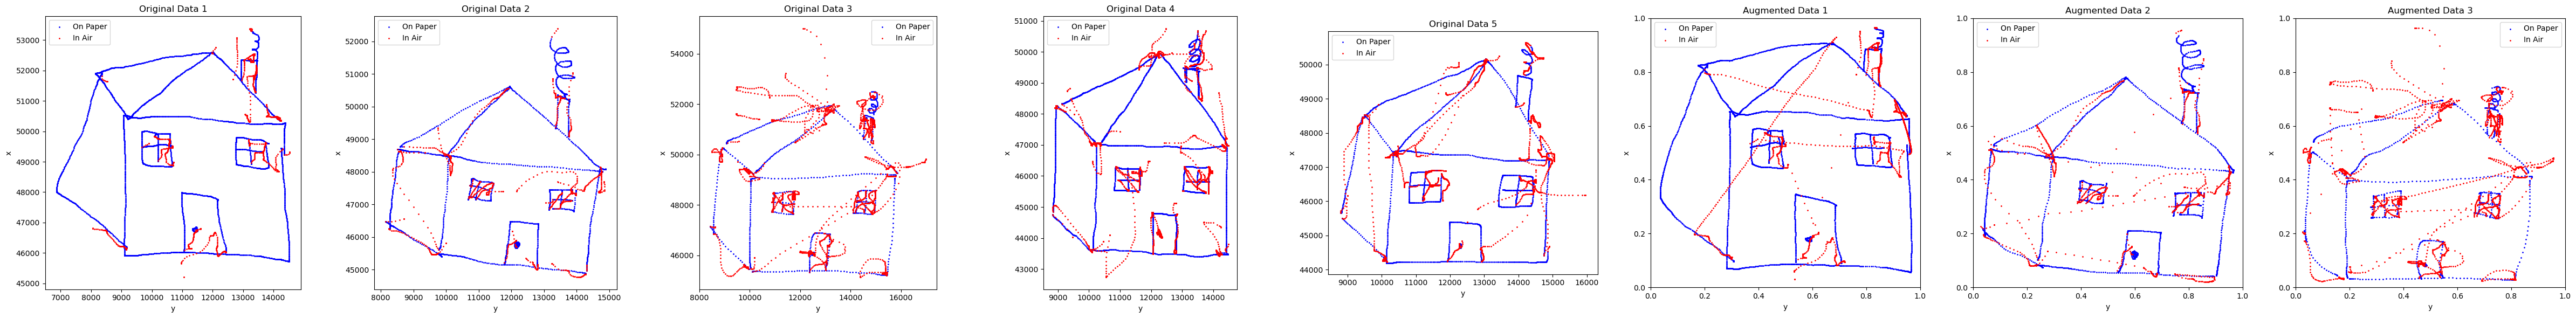

Epoch 101/200: 100%|██████████| 48/48 [00:03<00:00, 15.57batch/s, Generator Loss=6.48e-5, Reconstruction Loss=6.08e-5, KL Loss=4.01]  


Epoch 101: Generator Loss = 0.000087, Reconstruction Loss = 0.000083, KL Divergence Loss = 4.253698
NRMSE = 0.310942


Epoch 102/200: 100%|██████████| 48/48 [00:02<00:00, 17.26batch/s, Generator Loss=9.43e-5, Reconstruction Loss=9.03e-5, KL Loss=4.06]  


Epoch 102: Generator Loss = 0.000188, Reconstruction Loss = 0.000184, KL Divergence Loss = 4.250395
NRMSE = 0.310390


Epoch 103/200: 100%|██████████| 48/48 [00:02<00:00, 17.05batch/s, Generator Loss=5.62e-5, Reconstruction Loss=5.22e-5, KL Loss=4.01]  


Epoch 103: Generator Loss = 0.000086, Reconstruction Loss = 0.000082, KL Divergence Loss = 4.228916
NRMSE = 0.310212


Epoch 104/200: 100%|██████████| 48/48 [00:02<00:00, 16.10batch/s, Generator Loss=6.92e-5, Reconstruction Loss=6.51e-5, KL Loss=4.03]  


Epoch 104: Generator Loss = 0.000121, Reconstruction Loss = 0.000117, KL Divergence Loss = 4.255354
NRMSE = 0.310048


Epoch 105/200: 100%|██████████| 48/48 [00:02<00:00, 16.86batch/s, Generator Loss=7.46e-5, Reconstruction Loss=7.05e-5, KL Loss=4.07]  


Epoch 105: Generator Loss = 0.000097, Reconstruction Loss = 0.000092, KL Divergence Loss = 4.262996
NRMSE = 0.310638


Epoch 106/200: 100%|██████████| 48/48 [00:03<00:00, 15.99batch/s, Generator Loss=9.63e-5, Reconstruction Loss=9.22e-5, KL Loss=4.11]  


Epoch 106: Generator Loss = 0.000139, Reconstruction Loss = 0.000135, KL Divergence Loss = 4.264647
NRMSE = 0.310180


Epoch 107/200: 100%|██████████| 48/48 [00:02<00:00, 16.77batch/s, Generator Loss=5.62e-5, Reconstruction Loss=5.21e-5, KL Loss=4.09]  


Epoch 107: Generator Loss = 0.000107, Reconstruction Loss = 0.000103, KL Divergence Loss = 4.263253
NRMSE = 0.310680


Epoch 108/200: 100%|██████████| 48/48 [00:02<00:00, 16.77batch/s, Generator Loss=6.97e-5, Reconstruction Loss=6.57e-5, KL Loss=4.03]  


Epoch 108: Generator Loss = 0.000075, Reconstruction Loss = 0.000071, KL Divergence Loss = 4.281915
NRMSE = 0.310523


Epoch 109/200: 100%|██████████| 48/48 [00:03<00:00, 15.08batch/s, Generator Loss=5.4e-5, Reconstruction Loss=4.99e-5, KL Loss=4.04]   


Epoch 109: Generator Loss = 0.000111, Reconstruction Loss = 0.000107, KL Divergence Loss = 4.303486
NRMSE = 0.310890


Epoch 110/200: 100%|██████████| 48/48 [00:03<00:00, 15.50batch/s, Generator Loss=7.11e-5, Reconstruction Loss=6.69e-5, KL Loss=4.16]  


Epoch 110: Generator Loss = 0.000084, Reconstruction Loss = 0.000080, KL Divergence Loss = 4.302101
NRMSE = 0.310054


Epoch 111/200: 100%|██████████| 48/48 [00:02<00:00, 16.44batch/s, Generator Loss=6.41e-5, Reconstruction Loss=6.01e-5, KL Loss=4.03]  


Epoch 111: Generator Loss = 0.000106, Reconstruction Loss = 0.000101, KL Divergence Loss = 4.312113
NRMSE = 0.310647


Epoch 112/200: 100%|██████████| 48/48 [00:02<00:00, 16.71batch/s, Generator Loss=5.98e-5, Reconstruction Loss=5.57e-5, KL Loss=4.11]  


Epoch 112: Generator Loss = 0.000115, Reconstruction Loss = 0.000110, KL Divergence Loss = 4.304541
NRMSE = 0.309860


Epoch 113/200: 100%|██████████| 48/48 [00:02<00:00, 16.73batch/s, Generator Loss=6.79e-5, Reconstruction Loss=6.38e-5, KL Loss=4.03]  


Epoch 113: Generator Loss = 0.000154, Reconstruction Loss = 0.000149, KL Divergence Loss = 4.302554
NRMSE = 0.310764


Epoch 114/200: 100%|██████████| 48/48 [00:02<00:00, 16.59batch/s, Generator Loss=6.19e-5, Reconstruction Loss=5.78e-5, KL Loss=4.05]  


Epoch 114: Generator Loss = 0.000152, Reconstruction Loss = 0.000147, KL Divergence Loss = 4.251722
NRMSE = 0.309234


Epoch 115/200: 100%|██████████| 48/48 [00:02<00:00, 16.83batch/s, Generator Loss=9.02e-5, Reconstruction Loss=8.61e-5, KL Loss=4.15]  


Epoch 115: Generator Loss = 0.000097, Reconstruction Loss = 0.000093, KL Divergence Loss = 4.267232
NRMSE = 0.310108


Epoch 116/200: 100%|██████████| 48/48 [00:02<00:00, 16.55batch/s, Generator Loss=6.37e-5, Reconstruction Loss=5.96e-5, KL Loss=4.08]  


Epoch 116: Generator Loss = 0.000117, Reconstruction Loss = 0.000113, KL Divergence Loss = 4.282862
NRMSE = 0.309785


Epoch 117/200: 100%|██████████| 48/48 [00:02<00:00, 16.10batch/s, Generator Loss=5.21e-5, Reconstruction Loss=4.79e-5, KL Loss=4.19]  


Epoch 117: Generator Loss = 0.000075, Reconstruction Loss = 0.000070, KL Divergence Loss = 4.295876
NRMSE = 0.310716


Epoch 118/200: 100%|██████████| 48/48 [00:02<00:00, 16.69batch/s, Generator Loss=7.97e-5, Reconstruction Loss=7.55e-5, KL Loss=4.11]  


Epoch 118: Generator Loss = 0.000106, Reconstruction Loss = 0.000102, KL Divergence Loss = 4.317575
NRMSE = 0.310628


Epoch 119/200: 100%|██████████| 48/48 [00:02<00:00, 16.80batch/s, Generator Loss=7.97e-5, Reconstruction Loss=7.55e-5, KL Loss=4.16]  


Epoch 119: Generator Loss = 0.000102, Reconstruction Loss = 0.000098, KL Divergence Loss = 4.307869
NRMSE = 0.309472


Epoch 120/200: 100%|██████████| 48/48 [00:03<00:00, 15.17batch/s, Generator Loss=5.1e-5, Reconstruction Loss=4.69e-5, KL Loss=4.12]   


Epoch 120: Generator Loss = 0.000067, Reconstruction Loss = 0.000063, KL Divergence Loss = 4.332475
NRMSE = 0.310815


Epoch 121/200: 100%|██████████| 48/48 [00:02<00:00, 16.69batch/s, Generator Loss=6.38e-5, Reconstruction Loss=5.96e-5, KL Loss=4.2]   


Epoch 121: Generator Loss = 0.000100, Reconstruction Loss = 0.000096, KL Divergence Loss = 4.341919
NRMSE = 0.310135


Epoch 122/200: 100%|██████████| 48/48 [00:02<00:00, 16.21batch/s, Generator Loss=5.57e-5, Reconstruction Loss=5.17e-5, KL Loss=4.03]  


Epoch 122: Generator Loss = 0.000090, Reconstruction Loss = 0.000086, KL Divergence Loss = 4.340017
NRMSE = 0.310480


Epoch 123/200: 100%|██████████| 48/48 [00:02<00:00, 16.02batch/s, Generator Loss=4.85e-5, Reconstruction Loss=4.43e-5, KL Loss=4.18]  


Epoch 123: Generator Loss = 0.000097, Reconstruction Loss = 0.000092, KL Divergence Loss = 4.350490
NRMSE = 0.309853


Epoch 124/200: 100%|██████████| 48/48 [00:03<00:00, 15.63batch/s, Generator Loss=8.34e-5, Reconstruction Loss=7.93e-5, KL Loss=4.07]  


Epoch 124: Generator Loss = 0.000124, Reconstruction Loss = 0.000120, KL Divergence Loss = 4.340648
NRMSE = 0.309049


Epoch 125/200: 100%|██████████| 48/48 [00:02<00:00, 16.58batch/s, Generator Loss=4.6e-5, Reconstruction Loss=4.18e-5, KL Loss=4.2]    


Epoch 125: Generator Loss = 0.000081, Reconstruction Loss = 0.000077, KL Divergence Loss = 4.336214
NRMSE = 0.310173


Epoch 126/200: 100%|██████████| 48/48 [00:02<00:00, 16.82batch/s, Generator Loss=4.82e-5, Reconstruction Loss=4.41e-5, KL Loss=4.13]  


Epoch 126: Generator Loss = 0.000073, Reconstruction Loss = 0.000069, KL Divergence Loss = 4.361653
NRMSE = 0.309825


Epoch 127/200: 100%|██████████| 48/48 [00:02<00:00, 16.77batch/s, Generator Loss=9.51e-5, Reconstruction Loss=9.11e-5, KL Loss=4.08]  


Epoch 127: Generator Loss = 0.000175, Reconstruction Loss = 0.000170, KL Divergence Loss = 4.353316
NRMSE = 0.308545


Epoch 128/200: 100%|██████████| 48/48 [00:02<00:00, 16.36batch/s, Generator Loss=4.81e-5, Reconstruction Loss=4.4e-5, KL Loss=4.11]   


Epoch 128: Generator Loss = 0.000109, Reconstruction Loss = 0.000104, KL Divergence Loss = 4.303017
NRMSE = 0.309680


Epoch 129/200: 100%|██████████| 48/48 [00:02<00:00, 16.63batch/s, Generator Loss=4.01e-5, Reconstruction Loss=3.61e-5, KL Loss=4.06]  


Epoch 129: Generator Loss = 0.000070, Reconstruction Loss = 0.000066, KL Divergence Loss = 4.333375
NRMSE = 0.309429


Epoch 130/200: 100%|██████████| 48/48 [00:02<00:00, 16.89batch/s, Generator Loss=4.86e-5, Reconstruction Loss=4.44e-5, KL Loss=4.16]  


Epoch 130: Generator Loss = 0.000079, Reconstruction Loss = 0.000075, KL Divergence Loss = 4.357271
NRMSE = 0.309500


Epoch 131/200: 100%|██████████| 48/48 [00:03<00:00, 15.62batch/s, Generator Loss=4.75e-5, Reconstruction Loss=4.33e-5, KL Loss=4.12]  


Epoch 131: Generator Loss = 0.000098, Reconstruction Loss = 0.000094, KL Divergence Loss = 4.356083
NRMSE = 0.309647


Epoch 132/200: 100%|██████████| 48/48 [00:02<00:00, 16.85batch/s, Generator Loss=4.9e-5, Reconstruction Loss=4.48e-5, KL Loss=4.21]   


Epoch 132: Generator Loss = 0.000093, Reconstruction Loss = 0.000089, KL Divergence Loss = 4.349473
NRMSE = 0.310128


Epoch 133/200: 100%|██████████| 48/48 [00:03<00:00, 15.13batch/s, Generator Loss=4.53e-5, Reconstruction Loss=4.11e-5, KL Loss=4.18]  


Epoch 133: Generator Loss = 0.000083, Reconstruction Loss = 0.000079, KL Divergence Loss = 4.359470
NRMSE = 0.310095


Epoch 134/200: 100%|██████████| 48/48 [00:02<00:00, 16.06batch/s, Generator Loss=6.15e-5, Reconstruction Loss=5.74e-5, KL Loss=4.15]  


Epoch 134: Generator Loss = 0.000104, Reconstruction Loss = 0.000099, KL Divergence Loss = 4.361090
NRMSE = 0.309304


Epoch 135/200: 100%|██████████| 48/48 [00:02<00:00, 16.60batch/s, Generator Loss=4.28e-5, Reconstruction Loss=3.85e-5, KL Loss=4.26]  


Epoch 135: Generator Loss = 0.000068, Reconstruction Loss = 0.000064, KL Divergence Loss = 4.365751
NRMSE = 0.309202


Epoch 136/200: 100%|██████████| 48/48 [00:03<00:00, 13.80batch/s, Generator Loss=4.9e-5, Reconstruction Loss=4.49e-5, KL Loss=4.08]   


Epoch 136: Generator Loss = 0.000088, Reconstruction Loss = 0.000084, KL Divergence Loss = 4.379384
NRMSE = 0.310144


Epoch 137/200: 100%|██████████| 48/48 [00:02<00:00, 16.24batch/s, Generator Loss=4.6e-5, Reconstruction Loss=4.18e-5, KL Loss=4.19]   


Epoch 137: Generator Loss = 0.000101, Reconstruction Loss = 0.000097, KL Divergence Loss = 4.374085
NRMSE = 0.309667


Epoch 138/200: 100%|██████████| 48/48 [00:02<00:00, 16.42batch/s, Generator Loss=4.75e-5, Reconstruction Loss=4.34e-5, KL Loss=4.16]  


Epoch 138: Generator Loss = 0.000084, Reconstruction Loss = 0.000079, KL Divergence Loss = 4.375337
NRMSE = 0.308268


Epoch 139/200: 100%|██████████| 48/48 [00:02<00:00, 16.25batch/s, Generator Loss=4.03e-5, Reconstruction Loss=3.62e-5, KL Loss=4.12]  


Epoch 139: Generator Loss = 0.000095, Reconstruction Loss = 0.000091, KL Divergence Loss = 4.378134
NRMSE = 0.309169


Epoch 140/200: 100%|██████████| 48/48 [00:03<00:00, 15.93batch/s, Generator Loss=7.98e-5, Reconstruction Loss=7.57e-5, KL Loss=4.1]   


Epoch 140: Generator Loss = 0.000148, Reconstruction Loss = 0.000144, KL Divergence Loss = 4.368438
NRMSE = 0.308639


Epoch 141/200: 100%|██████████| 48/48 [00:02<00:00, 16.49batch/s, Generator Loss=4.15e-5, Reconstruction Loss=3.74e-5, KL Loss=4.15]  


Epoch 141: Generator Loss = 0.000085, Reconstruction Loss = 0.000081, KL Divergence Loss = 4.345531
NRMSE = 0.308294


Epoch 142/200: 100%|██████████| 48/48 [00:02<00:00, 16.74batch/s, Generator Loss=4.76e-5, Reconstruction Loss=4.35e-5, KL Loss=4.17]  


Epoch 142: Generator Loss = 0.000073, Reconstruction Loss = 0.000069, KL Divergence Loss = 4.374918
NRMSE = 0.308274


Epoch 143/200: 100%|██████████| 48/48 [00:02<00:00, 16.78batch/s, Generator Loss=4.67e-5, Reconstruction Loss=4.25e-5, KL Loss=4.18]  


Epoch 143: Generator Loss = 0.000077, Reconstruction Loss = 0.000073, KL Divergence Loss = 4.388455
NRMSE = 0.309019


Epoch 144/200: 100%|██████████| 48/48 [00:02<00:00, 16.40batch/s, Generator Loss=5.04e-5, Reconstruction Loss=4.62e-5, KL Loss=4.19]  


Epoch 144: Generator Loss = 0.000080, Reconstruction Loss = 0.000075, KL Divergence Loss = 4.400593
NRMSE = 0.308806


Epoch 145/200: 100%|██████████| 48/48 [00:02<00:00, 16.30batch/s, Generator Loss=6.37e-5, Reconstruction Loss=5.95e-5, KL Loss=4.18]  


Epoch 145: Generator Loss = 0.000199, Reconstruction Loss = 0.000194, KL Divergence Loss = 4.358468
NRMSE = 0.308109


Epoch 146/200: 100%|██████████| 48/48 [00:02<00:00, 16.89batch/s, Generator Loss=4.58e-5, Reconstruction Loss=4.16e-5, KL Loss=4.18]  


Epoch 146: Generator Loss = 0.000076, Reconstruction Loss = 0.000072, KL Divergence Loss = 4.341747
NRMSE = 0.309478


Epoch 147/200: 100%|██████████| 48/48 [00:02<00:00, 16.68batch/s, Generator Loss=6.94e-5, Reconstruction Loss=6.51e-5, KL Loss=4.27]


Epoch 147: Generator Loss = 0.000058, Reconstruction Loss = 0.000053, KL Divergence Loss = 4.381504
NRMSE = 0.308860


Epoch 148/200: 100%|██████████| 48/48 [00:02<00:00, 16.28batch/s, Generator Loss=4.07e-5, Reconstruction Loss=3.64e-5, KL Loss=4.21]  


Epoch 148: Generator Loss = 0.000072, Reconstruction Loss = 0.000067, KL Divergence Loss = 4.401082
NRMSE = 0.308219


Epoch 149/200: 100%|██████████| 48/48 [00:02<00:00, 16.66batch/s, Generator Loss=3.97e-5, Reconstruction Loss=3.55e-5, KL Loss=4.22]  


Epoch 149: Generator Loss = 0.000073, Reconstruction Loss = 0.000069, KL Divergence Loss = 4.412576
NRMSE = 0.308887


Epoch 150/200: 100%|██████████| 48/48 [00:02<00:00, 16.13batch/s, Generator Loss=6.17e-5, Reconstruction Loss=5.74e-5, KL Loss=4.26]  


Epoch 150: Generator Loss = 0.000074, Reconstruction Loss = 0.000069, KL Divergence Loss = 4.428123
NRMSE = 0.308735


Epoch 151/200: 100%|██████████| 48/48 [00:02<00:00, 16.74batch/s, Generator Loss=4.45e-5, Reconstruction Loss=4.02e-5, KL Loss=4.29]  


Epoch 151: Generator Loss = 0.000074, Reconstruction Loss = 0.000070, KL Divergence Loss = 4.431744
NRMSE = 0.309459


Epoch 152/200: 100%|██████████| 48/48 [00:02<00:00, 16.81batch/s, Generator Loss=0.000104, Reconstruction Loss=0.0001, KL Loss=4.2]   


Epoch 152: Generator Loss = 0.000161, Reconstruction Loss = 0.000157, KL Divergence Loss = 4.418557
NRMSE = 0.308094


Epoch 153/200: 100%|██████████| 48/48 [00:03<00:00, 14.18batch/s, Generator Loss=4.14e-5, Reconstruction Loss=3.72e-5, KL Loss=4.23]  


Epoch 153: Generator Loss = 0.000066, Reconstruction Loss = 0.000062, KL Divergence Loss = 4.391260
NRMSE = 0.308788


Epoch 154/200: 100%|██████████| 48/48 [00:02<00:00, 16.56batch/s, Generator Loss=3.75e-5, Reconstruction Loss=3.33e-5, KL Loss=4.17]  


Epoch 154: Generator Loss = 0.000065, Reconstruction Loss = 0.000061, KL Divergence Loss = 4.419710
NRMSE = 0.308935


Epoch 155/200: 100%|██████████| 48/48 [00:02<00:00, 16.22batch/s, Generator Loss=5.01e-5, Reconstruction Loss=4.6e-5, KL Loss=4.16]   


Epoch 155: Generator Loss = 0.000075, Reconstruction Loss = 0.000071, KL Divergence Loss = 4.432688
NRMSE = 0.308952


Epoch 156/200: 100%|██████████| 48/48 [00:03<00:00, 15.31batch/s, Generator Loss=4.78e-5, Reconstruction Loss=4.37e-5, KL Loss=4.18]  


Epoch 156: Generator Loss = 0.000127, Reconstruction Loss = 0.000122, KL Divergence Loss = 4.424468
NRMSE = 0.309511


Epoch 157/200: 100%|██████████| 48/48 [00:02<00:00, 16.44batch/s, Generator Loss=4.88e-5, Reconstruction Loss=4.46e-5, KL Loss=4.23]  


Epoch 157: Generator Loss = 0.000079, Reconstruction Loss = 0.000074, KL Divergence Loss = 4.409008
NRMSE = 0.308350


Epoch 158/200: 100%|██████████| 48/48 [00:02<00:00, 16.57batch/s, Generator Loss=5.07e-5, Reconstruction Loss=4.65e-5, KL Loss=4.22]  


Epoch 158: Generator Loss = 0.000067, Reconstruction Loss = 0.000063, KL Divergence Loss = 4.431861
NRMSE = 0.309049


Epoch 159/200: 100%|██████████| 48/48 [00:02<00:00, 16.12batch/s, Generator Loss=6.56e-5, Reconstruction Loss=6.14e-5, KL Loss=4.17]  


Epoch 159: Generator Loss = 0.000208, Reconstruction Loss = 0.000203, KL Divergence Loss = 4.392553
NRMSE = 0.307624


Epoch 160/200: 100%|██████████| 48/48 [00:03<00:00, 15.24batch/s, Generator Loss=5.25e-5, Reconstruction Loss=4.84e-5, KL Loss=4.1]   


Epoch 160: Generator Loss = 0.000070, Reconstruction Loss = 0.000066, KL Divergence Loss = 4.354950
NRMSE = 0.307893


Epoch 161/200: 100%|██████████| 48/48 [00:02<00:00, 16.28batch/s, Generator Loss=4.05e-5, Reconstruction Loss=3.63e-5, KL Loss=4.2]   


Epoch 161: Generator Loss = 0.000068, Reconstruction Loss = 0.000064, KL Divergence Loss = 4.391183
NRMSE = 0.307353


Epoch 162/200: 100%|██████████| 48/48 [00:02<00:00, 16.33batch/s, Generator Loss=4.97e-5, Reconstruction Loss=4.55e-5, KL Loss=4.21]  


Epoch 162: Generator Loss = 0.000085, Reconstruction Loss = 0.000080, KL Divergence Loss = 4.411425
NRMSE = 0.306764


Epoch 163/200: 100%|██████████| 48/48 [00:02<00:00, 16.49batch/s, Generator Loss=5.29e-5, Reconstruction Loss=4.87e-5, KL Loss=4.26]  


Epoch 163: Generator Loss = 0.000078, Reconstruction Loss = 0.000073, KL Divergence Loss = 4.406007
NRMSE = 0.307428


Epoch 164/200: 100%|██████████| 48/48 [00:03<00:00, 14.61batch/s, Generator Loss=5.89e-5, Reconstruction Loss=5.46e-5, KL Loss=4.29]  


Epoch 164: Generator Loss = 0.000074, Reconstruction Loss = 0.000070, KL Divergence Loss = 4.428046
NRMSE = 0.307322


Epoch 165/200: 100%|██████████| 48/48 [00:03<00:00, 15.79batch/s, Generator Loss=3.47e-5, Reconstruction Loss=3.04e-5, KL Loss=4.3]   


Epoch 165: Generator Loss = 0.000061, Reconstruction Loss = 0.000056, KL Divergence Loss = 4.438631
NRMSE = 0.307782


Epoch 166/200: 100%|██████████| 48/48 [00:02<00:00, 16.28batch/s, Generator Loss=7.7e-5, Reconstruction Loss=7.28e-5, KL Loss=4.19]   


Epoch 166: Generator Loss = 0.000096, Reconstruction Loss = 0.000092, KL Divergence Loss = 4.444160
NRMSE = 0.307153


Epoch 167/200: 100%|██████████| 48/48 [00:02<00:00, 16.74batch/s, Generator Loss=4.71e-5, Reconstruction Loss=4.29e-5, KL Loss=4.25]  


Epoch 167: Generator Loss = 0.000087, Reconstruction Loss = 0.000083, KL Divergence Loss = 4.421663
NRMSE = 0.307346


Epoch 168/200: 100%|██████████| 48/48 [00:02<00:00, 16.21batch/s, Generator Loss=4.21e-5, Reconstruction Loss=3.79e-5, KL Loss=4.24]  


Epoch 168: Generator Loss = 0.000080, Reconstruction Loss = 0.000076, KL Divergence Loss = 4.423777
NRMSE = 0.306630


Epoch 169/200: 100%|██████████| 48/48 [00:02<00:00, 16.29batch/s, Generator Loss=4.62e-5, Reconstruction Loss=4.19e-5, KL Loss=4.22]  


Epoch 169: Generator Loss = 0.000075, Reconstruction Loss = 0.000070, KL Divergence Loss = 4.431006
NRMSE = 0.306500


Epoch 170/200: 100%|██████████| 48/48 [00:03<00:00, 15.79batch/s, Generator Loss=5.44e-5, Reconstruction Loss=5.01e-5, KL Loss=4.31]  


Epoch 170: Generator Loss = 0.000092, Reconstruction Loss = 0.000087, KL Divergence Loss = 4.434770
NRMSE = 0.306856


Epoch 171/200: 100%|██████████| 48/48 [00:03<00:00, 15.48batch/s, Generator Loss=5.08e-5, Reconstruction Loss=4.65e-5, KL Loss=4.26]  


Epoch 171: Generator Loss = 0.000124, Reconstruction Loss = 0.000120, KL Divergence Loss = 4.413227
NRMSE = 0.306866


Epoch 172/200: 100%|██████████| 48/48 [00:03<00:00, 15.81batch/s, Generator Loss=4.16e-5, Reconstruction Loss=3.74e-5, KL Loss=4.19]  


Epoch 172: Generator Loss = 0.000068, Reconstruction Loss = 0.000064, KL Divergence Loss = 4.413972
NRMSE = 0.306265


Epoch 173/200: 100%|██████████| 48/48 [00:02<00:00, 16.29batch/s, Generator Loss=3.51e-5, Reconstruction Loss=3.09e-5, KL Loss=4.17]  


Epoch 173: Generator Loss = 0.000074, Reconstruction Loss = 0.000070, KL Divergence Loss = 4.430067
NRMSE = 0.306749


Epoch 174/200: 100%|██████████| 48/48 [00:02<00:00, 16.83batch/s, Generator Loss=4.01e-5, Reconstruction Loss=3.59e-5, KL Loss=4.19]  


Epoch 174: Generator Loss = 0.000077, Reconstruction Loss = 0.000072, KL Divergence Loss = 4.436147
NRMSE = 0.306354


Epoch 175/200: 100%|██████████| 48/48 [00:02<00:00, 16.01batch/s, Generator Loss=4.55e-5, Reconstruction Loss=4.12e-5, KL Loss=4.31]  


Epoch 175: Generator Loss = 0.000091, Reconstruction Loss = 0.000087, KL Divergence Loss = 4.445532
NRMSE = 0.307301


Epoch 176/200: 100%|██████████| 48/48 [00:02<00:00, 16.09batch/s, Generator Loss=5.14e-5, Reconstruction Loss=4.71e-5, KL Loss=4.23]  


Epoch 176: Generator Loss = 0.000078, Reconstruction Loss = 0.000074, KL Divergence Loss = 4.439063
NRMSE = 0.306123


Epoch 177/200: 100%|██████████| 48/48 [00:02<00:00, 16.72batch/s, Generator Loss=3.27e-5, Reconstruction Loss=2.84e-5, KL Loss=4.28] 


Epoch 177: Generator Loss = 0.000059, Reconstruction Loss = 0.000055, KL Divergence Loss = 4.456814
NRMSE = 0.306578


Epoch 178/200: 100%|██████████| 48/48 [00:02<00:00, 16.23batch/s, Generator Loss=4.06e-5, Reconstruction Loss=3.63e-5, KL Loss=4.23]  


Epoch 178: Generator Loss = 0.000071, Reconstruction Loss = 0.000067, KL Divergence Loss = 4.467412
NRMSE = 0.307142


Epoch 179/200: 100%|██████████| 48/48 [00:03<00:00, 15.94batch/s, Generator Loss=8.61e-5, Reconstruction Loss=8.19e-5, KL Loss=4.26]  


Epoch 179: Generator Loss = 0.000210, Reconstruction Loss = 0.000206, KL Divergence Loss = 4.420468
NRMSE = 0.305195


Epoch 180/200: 100%|██████████| 48/48 [00:03<00:00, 15.60batch/s, Generator Loss=4.25e-5, Reconstruction Loss=3.83e-5, KL Loss=4.21]  


Epoch 180: Generator Loss = 0.000096, Reconstruction Loss = 0.000091, KL Divergence Loss = 4.378326
NRMSE = 0.305327


Epoch 181/200: 100%|██████████| 48/48 [00:02<00:00, 16.30batch/s, Generator Loss=3.98e-5, Reconstruction Loss=3.56e-5, KL Loss=4.24]  


Epoch 181: Generator Loss = 0.000065, Reconstruction Loss = 0.000061, KL Divergence Loss = 4.410704
NRMSE = 0.305543


Epoch 182/200: 100%|██████████| 48/48 [00:02<00:00, 16.18batch/s, Generator Loss=4.11e-5, Reconstruction Loss=3.69e-5, KL Loss=4.25]  


Epoch 182: Generator Loss = 0.000052, Reconstruction Loss = 0.000048, KL Divergence Loss = 4.435619
NRMSE = 0.305745


Epoch 183/200: 100%|██████████| 48/48 [00:02<00:00, 16.09batch/s, Generator Loss=4.59e-5, Reconstruction Loss=4.16e-5, KL Loss=4.29]  


Epoch 183: Generator Loss = 0.000065, Reconstruction Loss = 0.000060, KL Divergence Loss = 4.452764
NRMSE = 0.305476


Epoch 184/200: 100%|██████████| 48/48 [00:03<00:00, 15.74batch/s, Generator Loss=4.47e-5, Reconstruction Loss=4.05e-5, KL Loss=4.24] 


Epoch 184: Generator Loss = 0.000060, Reconstruction Loss = 0.000056, KL Divergence Loss = 4.463663
NRMSE = 0.305760


Epoch 185/200: 100%|██████████| 48/48 [00:02<00:00, 16.09batch/s, Generator Loss=6.63e-5, Reconstruction Loss=6.19e-5, KL Loss=4.36]  


Epoch 185: Generator Loss = 0.000069, Reconstruction Loss = 0.000065, KL Divergence Loss = 4.478255
NRMSE = 0.306021


Epoch 186/200: 100%|██████████| 48/48 [00:03<00:00, 15.82batch/s, Generator Loss=4.25e-5, Reconstruction Loss=3.82e-5, KL Loss=4.33]  


Epoch 186: Generator Loss = 0.000096, Reconstruction Loss = 0.000092, KL Divergence Loss = 4.457616
NRMSE = 0.306077


Epoch 187/200: 100%|██████████| 48/48 [00:02<00:00, 16.53batch/s, Generator Loss=5.64e-5, Reconstruction Loss=5.21e-5, KL Loss=4.26]  


Epoch 187: Generator Loss = 0.000079, Reconstruction Loss = 0.000075, KL Divergence Loss = 4.456040
NRMSE = 0.305300


Epoch 188/200: 100%|██████████| 48/48 [00:02<00:00, 16.42batch/s, Generator Loss=4.95e-5, Reconstruction Loss=4.53e-5, KL Loss=4.22]  


Epoch 188: Generator Loss = 0.000085, Reconstruction Loss = 0.000080, KL Divergence Loss = 4.458136
NRMSE = 0.306149


Epoch 189/200: 100%|██████████| 48/48 [00:03<00:00, 15.79batch/s, Generator Loss=5.68e-5, Reconstruction Loss=5.26e-5, KL Loss=4.23]  


Epoch 189: Generator Loss = 0.000076, Reconstruction Loss = 0.000071, KL Divergence Loss = 4.461526
NRMSE = 0.305075


Epoch 190/200: 100%|██████████| 48/48 [00:02<00:00, 16.24batch/s, Generator Loss=3.61e-5, Reconstruction Loss=3.19e-5, KL Loss=4.21]  


Epoch 190: Generator Loss = 0.000077, Reconstruction Loss = 0.000072, KL Divergence Loss = 4.458709
NRMSE = 0.305054


Epoch 191/200: 100%|██████████| 48/48 [00:03<00:00, 15.97batch/s, Generator Loss=5.31e-5, Reconstruction Loss=4.88e-5, KL Loss=4.31]  


Epoch 191: Generator Loss = 0.000063, Reconstruction Loss = 0.000058, KL Divergence Loss = 4.472044
NRMSE = 0.306226


Epoch 192/200: 100%|██████████| 48/48 [00:02<00:00, 16.08batch/s, Generator Loss=4.05e-5, Reconstruction Loss=3.62e-5, KL Loss=4.3]   


Epoch 192: Generator Loss = 0.000084, Reconstruction Loss = 0.000079, KL Divergence Loss = 4.474490
NRMSE = 0.305494


Epoch 193/200: 100%|██████████| 48/48 [00:03<00:00, 15.64batch/s, Generator Loss=3.52e-5, Reconstruction Loss=3.08e-5, KL Loss=4.31]  


Epoch 193: Generator Loss = 0.000079, Reconstruction Loss = 0.000075, KL Divergence Loss = 4.468695
NRMSE = 0.306099


Epoch 194/200: 100%|██████████| 48/48 [00:02<00:00, 16.46batch/s, Generator Loss=3.45e-5, Reconstruction Loss=3.02e-5, KL Loss=4.25]  


Epoch 194: Generator Loss = 0.000076, Reconstruction Loss = 0.000071, KL Divergence Loss = 4.465744
NRMSE = 0.305334


Epoch 195/200: 100%|██████████| 48/48 [00:02<00:00, 16.15batch/s, Generator Loss=3.74e-5, Reconstruction Loss=3.31e-5, KL Loss=4.25] 


Epoch 195: Generator Loss = 0.000068, Reconstruction Loss = 0.000064, KL Divergence Loss = 4.470407
NRMSE = 0.305523


Epoch 196/200: 100%|██████████| 48/48 [00:03<00:00, 15.84batch/s, Generator Loss=5.17e-5, Reconstruction Loss=4.74e-5, KL Loss=4.26]  


Epoch 196: Generator Loss = 0.000075, Reconstruction Loss = 0.000070, KL Divergence Loss = 4.473246
NRMSE = 0.306195


Epoch 197/200: 100%|██████████| 48/48 [00:02<00:00, 16.29batch/s, Generator Loss=5.11e-5, Reconstruction Loss=4.69e-5, KL Loss=4.22]  


Epoch 197: Generator Loss = 0.000100, Reconstruction Loss = 0.000095, KL Divergence Loss = 4.463022
NRMSE = 0.306832


Epoch 198/200: 100%|██████████| 48/48 [00:03<00:00, 15.77batch/s, Generator Loss=3.27e-5, Reconstruction Loss=2.84e-5, KL Loss=4.31]  


Epoch 198: Generator Loss = 0.000055, Reconstruction Loss = 0.000051, KL Divergence Loss = 4.466578
NRMSE = 0.305551


Epoch 199/200: 100%|██████████| 48/48 [00:02<00:00, 16.27batch/s, Generator Loss=3.51e-5, Reconstruction Loss=3.08e-5, KL Loss=4.26]  


Epoch 199: Generator Loss = 0.000061, Reconstruction Loss = 0.000056, KL Divergence Loss = 4.484687
NRMSE = 0.305670


Epoch 200/200: 100%|██████████| 48/48 [00:02<00:00, 16.15batch/s, Generator Loss=4.48e-5, Reconstruction Loss=4.05e-5, KL Loss=4.35]  


Epoch 200: Generator Loss = 0.000099, Reconstruction Loss = 0.000095, KL Divergence Loss = 4.471577
NRMSE = 0.304313


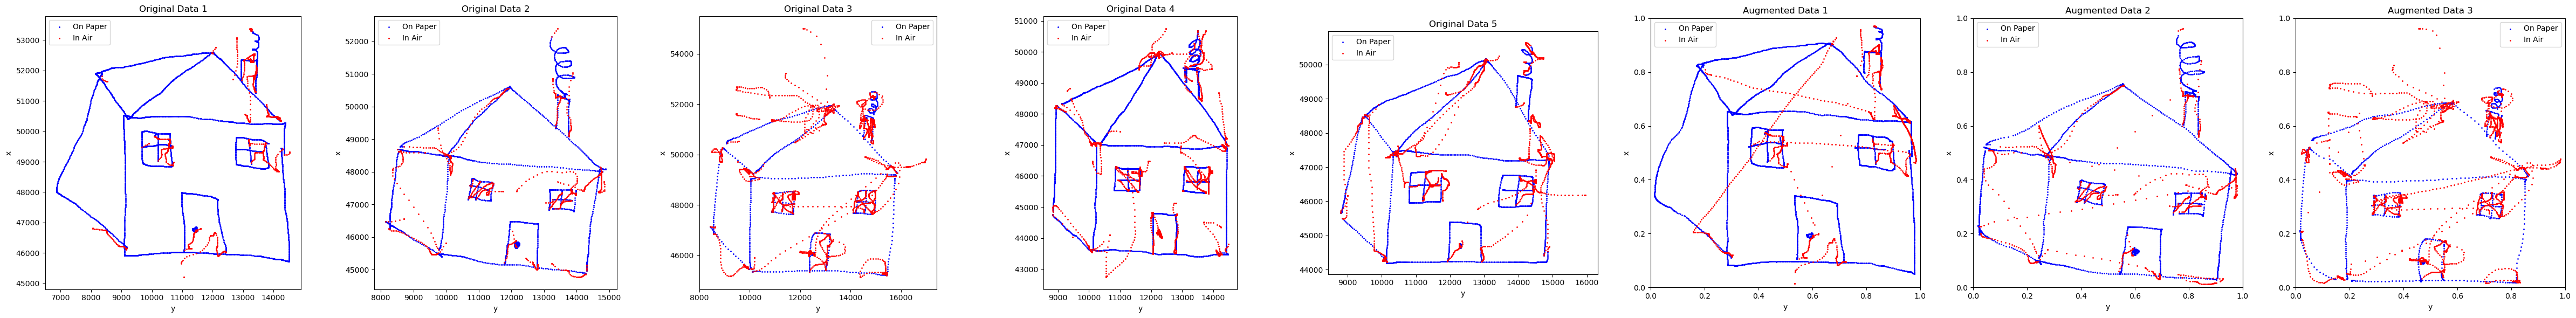

Final NRMSE: 0.304313
Training completed.
VAE model saved.


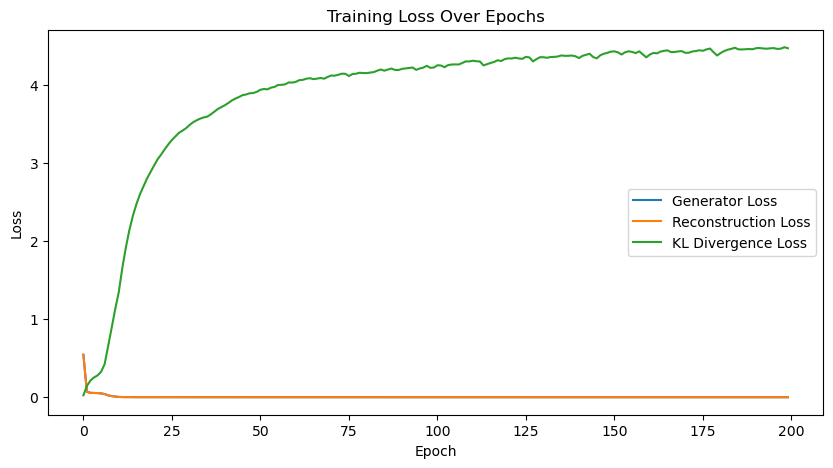

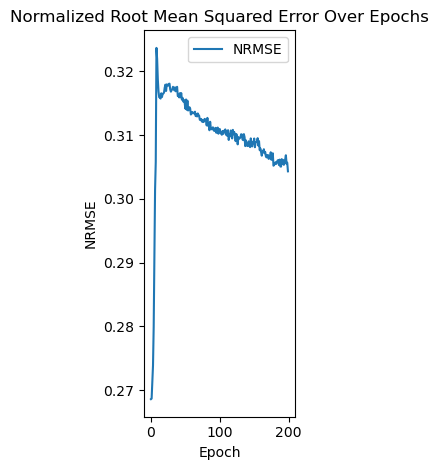

In [8]:
#Cell 8
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        # Add LSTM discriminator loss if available
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + total_kl_loss + 0.1 * discriminator_loss  # Adjust the weight as needed
        else:
            generator_loss = reconstruction_loss + total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 200
lstm_interval = 50
epochs = 200
visual_per_num_epoch = 100
num_augmented_files = 1

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                # Use LSTM discriminator after vae_epochs and every lstm_interval
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train the LSTM discriminator every lstm_interval epochs after vae_epochs
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)  # Reshape for LSTM input
            generated_data = tf.expand_dims(augmented_data, axis=0)

            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')

    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate NRMSE
    nrmse_sum = 0
    for data in processed_data:
        augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
        rmse = np.sqrt(mean_squared_error(data[:, :2], augmented_data[:, :2]))
        nrmse = rmse / (data[:, :2].max() - data[:, :2].min())
        nrmse_sum += nrmse
    
    nrmse_avg = nrmse_sum / len(processed_data)

    nrmse_history.append(nrmse_avg)

    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"NRMSE = {nrmse_avg:.6f}")

    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)
        num_augmented_files = 3

        # Generate augmented data using the pretrained model
        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                    base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        # Visualize the original and augmented data side by side
        fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6*(num_augmented_files + len(original_data_frames)), 6))

        # Plot the original data before imputation, with a 90-degree left rotation and horizontal flip
        for i, original_data in enumerate(original_data_frames):  # Use original_data_frames for raw data visualization
            original_on_paper = original_data[original_data['pen_status'] == 1]
            original_in_air = original_data[original_data['pen_status'] == 0]
            
            # Scatter plot for the original data (before imputation), with rotated axes
            axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')  # y -> x, x -> y
            axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')  # y -> x, x -> y
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].set_xlabel('y')  # Previously 'x'
            axs[i].set_ylabel('x')  # Previously 'y'
            axs[i].set_aspect('equal')
            axs[i].legend()
            
            # Flip the horizontal axis (y-axis)
            axs[i].invert_xaxis()  # This reverses the 'y' axis to flip the plot horizontally

        # Set consistent axis limits for square aspect ratio for both original and augmented data
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        # Plot the augmented data with the same 90-degree left rotation and horizontal flip
        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
            
            # Scatter plot for the augmented data, with rotated axes
            axs[i+len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')  # y -> x, x -> y
            axs[i+len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')  # y -> x, x -> y
            axs[i+len(original_data_frames)].set_title(f'Augmented Data {i+1}')
            axs[i+len(original_data_frames)].set_xlabel('y')  # Previously 'x'
            axs[i+len(original_data_frames)].set_ylabel('x')  # Previously 'y'
            axs[i+len(original_data_frames)].set_aspect('equal')
            axs[i+len(original_data_frames)].set_xlim(y_max, y_min)  # Reverse the 'y' axis for horizontal flip
            axs[i+len(original_data_frames)].set_ylim(x_min, x_max)  # Keep the vertical limits the same
            axs[i+len(original_data_frames)].legend()

        plt.tight_layout()
        plt.show()

# Final output of metrics
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

vae.save('pentab_saved_model.h5')
print("VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot NRMSE history
plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_lstm_classifier(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def prepare_data_for_lstm(real_data, synthetic_data):
    # Determine the number of features to use (minimum of real and synthetic data)
    n_features = min(real_data.shape[1], synthetic_data.shape[1])
    
    # Trim the features to match
    real_data_trimmed = real_data[:, :n_features]
    synthetic_data_trimmed = synthetic_data[:, :n_features]
    
    X = np.vstack((real_data_trimmed, synthetic_data_trimmed))
    y = np.concatenate((np.ones(len(real_data)), np.zeros(len(synthetic_data))))
    return X, y

def post_hoc_discriminative_score(real_data, synthetic_data, n_splits=10):
    X, y = prepare_data_for_lstm(real_data, synthetic_data)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Reshape the data for LSTM input (samples, timesteps, features)
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        model = create_lstm_classifier((1, X_train.shape[2]))
        model.fit(X_train, y_train, epochs=3, batch_size=256, verbose=0)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    return mean_accuracy, std_accuracy

# Assuming 'processed_data' contains the real data and 'augmented_datasets' contains the synthetic data
real_data = np.concatenate(processed_data, axis=0)
synthetic_data = np.concatenate(augmented_datasets, axis=0)

print(f"Real data shape: {real_data.shape}")
print(f"Synthetic data shape: {synthetic_data.shape}")

mean_accuracy, std_accuracy = post_hoc_discriminative_score(real_data, synthetic_data)

print(f"\nPost-Hoc Discriminative Score Results:")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

# Interpret the results
if abs(mean_accuracy - 0.5) < 0.05:
    print("\nThe synthetic data is effectively indistinguishable from real data.")
elif mean_accuracy > 0.55:
    print("\nThe classifier can distinguish between real and synthetic data with some accuracy.")
    print("This suggests that the synthetic data may not fully capture all characteristics of the real data.")
else:
    print("\nThe classifier performs worse than random guessing.")
    print("This might indicate issues with the classification process or highly varied data.")

Real data shape: (5971, 4)
Synthetic data shape: (17913, 7)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Post-Hoc Discriminative Score Results:
Mean Accuracy: 0.7500
Standard Deviation: 0.0050

The classifier can distinguish between real and synthetic data with some accuracy.
This suggests that the synthetic data may not fully capture all characteristics of the real data.


In [24]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

def prepare_data(data):
    """Prepare data for prediction (use all but last time step as input, last as target)."""
    X = data[:, :-1]  # All but last time step
    y = data[:, -1]   # Last time step
    return X, y

def post_hoc_predictive_score(synthetic_data, real_data, n_repeats=10):
    scaler = MinMaxScaler()
    synthetic_data_scaled = scaler.fit_transform(synthetic_data)
    real_data_scaled = scaler.transform(real_data)

    X_synthetic, y_synthetic = prepare_data(synthetic_data_scaled)
    X_real, y_real = prepare_data(real_data_scaled)

    mape_scores = []

    for _ in range(n_repeats):
        # Train on synthetic data
        model = LinearRegression()
        model.fit(X_synthetic, y_synthetic)

        # Predict on real data
        y_pred = model.predict(X_real)

        # Calculate MAPE
        mape = mean_absolute_percentage_error(y_real, y_pred)
        mape_scores.append(mape)

    mean_mape = np.mean(mape_scores)
    std_mape = np.std(mape_scores)

    return mean_mape, std_mape

# Assuming 'processed_data' contains the real data and 'augmented_datasets' contains the synthetic data
real_data = np.concatenate(processed_data, axis=0)
synthetic_data = np.concatenate(augmented_datasets, axis=0)

# Ensure both datasets have the same number of features
min_features = min(real_data.shape[1], synthetic_data.shape[1])
real_data = real_data[:, :min_features]
synthetic_data = synthetic_data[:, :min_features]

mean_mape, std_mape = post_hoc_predictive_score(synthetic_data, real_data)

print(f"Post-Hoc Predictive Score Results:")
print(f"Mean MAPE: {mean_mape:.4f}")
print(f"Standard Deviation of MAPE: {std_mape:.4f}")

# Interpret the results
if mean_mape < 0.1:
    print("\nThe synthetic data captures the patterns of the original data very well.")
elif mean_mape < 0.2:
    print("\nThe synthetic data captures the patterns of the original data reasonably well.")
else:
    print("\nThe synthetic data may not fully capture the patterns of the original data.")
    print("Consider refining the data generation process.")

Post-Hoc Predictive Score Results:
Mean MAPE: 825373093097945.0000
Standard Deviation of MAPE: 0.0000

The synthetic data may not fully capture the patterns of the original data.
Consider refining the data generation process.


In [1]:
# Cell 9 (modified to retain augmented data length)
def download_augmented_data_as_integers(augmented_datasets, scalers, original_data_frames, original_filenames, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        # Inverse transform the augmented data
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        
        # Round to integers
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        
        # Get pen status from augmented data
        pen_status = augmented_data[:, 3].astype(int)
        
        # Prepare pressure, azimuth, altitude data
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        # If augmented data is longer, extend original_paa by repeating the last row
        if len(augmented_data) > len(original_paa):
            last_row = original_paa[-1:]
            repeat_count = len(augmented_data) - len(original_paa)
            extended_rows = np.tile(last_row, (repeat_count, 1))
            original_paa = np.vstack((original_paa, extended_rows))
        
        # Round pressure, azimuth, altitude to integers
        original_paa_int = np.rint(original_paa).astype(int)
        
        # Combine all data
        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Construct the new file name to match the original file name
        augmented_filename = f"augmented_{original_filename}"
        augmented_file_path = os.path.join(directory, augmented_filename)

        # Save the augmented data to a file
        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

# Example call to the function
download_augmented_data_as_integers(augmented_datasets, scalers, original_data_frames, input_filenames)

# Add this diagnostic print statement after generating augmented_datasets
print("Shapes of augmented datasets:")
for i, aug_data in enumerate(augmented_datasets):
    print(f"Shape of augmented dataset {i+1}: {aug_data.shape}")

NameError: name 'augmented_datasets' is not defined

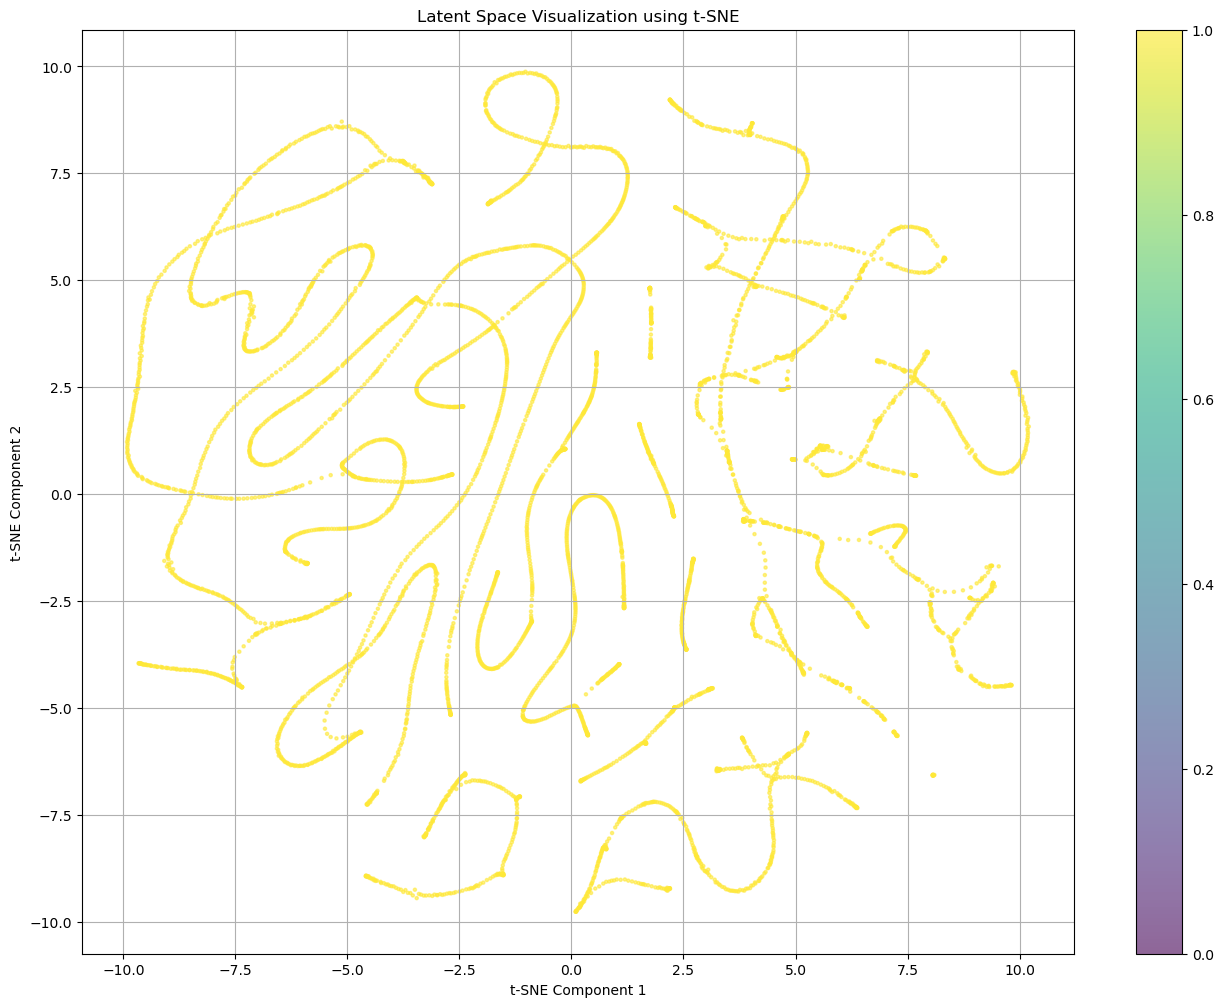

In [22]:
#Cell 11 Function to visualize the latent space with a color gradient
from sklearn.manifold import TSNE

def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])